# Copernicus Climate Data Store (CDS) API
- CDS documentation: https://confluence.ecmwf.int/display/CKB/Climate+Data+Store+%28CDS%29+documentation
- Developer and API documentation: https://cds.climate.copernicus.eu/toolbox/doc/index.html
- Use bboxfinder tool to select a suitable geographic bounding box: http://bboxfinder.com

In [1413]:
from pathlib import Path
from itertools import product
from math import radians
import json

import requests
import cdsapi
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.metrics.pairwise import haversine_distances

In [1385]:
# Set max number of columns to display; default 20
pd.options.display.max_columns = 80

In [1386]:
# Directory where data files will be downloaded
cwd_path = Path.cwd()
data_path = cwd_path.parent.joinpath('data')
data_push_path = cwd_path.parent.joinpath('data_to_push')

In [1452]:
# Make sure api key is in dot file in home dir
cds = cdsapi.Client()
print(cds.url)
print(cds.verify)
print(cds.timeout)

https://cds.climate.copernicus.eu/api/v2
True
60


#### Forming the API request
- From the documentation: "We strongly suggest to construct CDS API requests by using the CDS web interface of the relevant dataset and using the 'Show API request' button to get the code."
    - hourly data single levels: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview
    - hourly data pressure levels: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=overview

#### Suitable geographic bounding box that contains all of Germany
- Box coordinates (long,lat): 4.218,46.073,17.028,56.377
- CDS needs it in North(0 to 90), West(0 to -180), South(0 to -90), East (0 to 180). Default: global
    - That's `[56.38, 4.22, 46.07, 17.03]`

#### Data size and request duration
- One year of hourly 100m and 10m wind components (4 variables) for above bounding box is 150 MB
- API call took 17 minutes from queued, running to completed

#### Variables of interest
- `100m_u-component_of_wind`, `100m_v-component_of_wind` and 10m components have units `m s**-1` and  are single level, instantanous parameters
- instantaneous: Although they are valid at the specified time, and NOT an average over the model time step, such parameters cannot represent variability on short time scales. This arises because the model values are a grid box average, without variability on spatial scales smaller than the grid

In [1453]:
# Query partial year 2023
# cds.retrieve(
#     'reanalysis-era5-single-levels',
#     {
#         'product_type': 'reanalysis',
#         'format': 'netcdf',
#         'variable': [
#             '100m_u_component_of_wind', 
#             '100m_v_component_of_wind', 
#             '10m_u_component_of_wind',
#             '10m_v_component_of_wind',
#             '2m_temperature',
#             'instantaneous_10m_wind_gust',
#             'mean_sea_level_pressure'
#         ],
#         'year': '2023',
#         'month': [
#             '01', '02', '03',
#             '04', '05', '06',
#         ],
#         'day': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#             '13', '14', '15',
#             '16', '17', '18',
#             '19', '20', '21',
#             '22', '23', '24',
#             '25', '26', '27',
#             '28', '29', '30',
#             '31',
#         ],
#         'time': [
#             '00:00', '01:00', '02:00',
#             '03:00', '04:00', '05:00',
#             '06:00', '07:00', '08:00',
#             '09:00', '10:00', '11:00',
#             '12:00', '13:00', '14:00',
#             '15:00', '16:00', '17:00',
#             '18:00', '19:00', '20:00',
#             '21:00', '22:00', '23:00',
#         ],
#         'area': [
#             56.38, 4.22, 46.07,
#             17.03,
#         ],
#     },
#     str(data_path.joinpath('ERA5').joinpath('era5_2023_new.nc')))

2023-09-12 17:02:33,785 INFO Welcome to the CDS
2023-09-12 17:02:33,789 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-09-12 17:02:34,169 INFO Request is queued
2023-09-12 17:02:35,266 INFO Request is running
2023-09-12 17:20:55,637 INFO Request is completed
2023-09-12 17:20:55,644 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data1/adaptor.mars.internal-1694531942.2495763-1899-6-1fe7bc62-85ed-405d-935b-98c9705889a9.nc to /Users/brand/my_code/meteoviz/course_project/data/ERA5/era5_2023_new.nc (126.7M)
2023-09-12 17:21:18,444 INFO Download rate 5.6M/s                           


Result(content_length=132842536,content_type=application/x-netcdf,location=https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data1/adaptor.mars.internal-1694531942.2495763-1899-6-1fe7bc62-85ed-405d-935b-98c9705889a9.nc)

In [1399]:
# Fetch entire year of data

cds.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': [
            '100m_u_component_of_wind', 
            '100m_v_component_of_wind', 
            '10m_u_component_of_wind',
            '10m_v_component_of_wind',
            '2m_temperature',
            'instantaneous_10m_wind_gust',
            'mean_sea_level_pressure'
        ],
        'year': '2023',
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': [
            56.38, 4.22, 46.07,
            17.03,
        ],
    },
    str(data_path.joinpath('ERA5').joinpath('era5_2023.nc')))

2023-09-11 19:15:04,151 INFO Welcome to the CDS
2023-09-11 19:15:04,152 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-09-11 19:15:04,364 INFO Request is queued
2023-09-11 19:15:05,400 INFO Request is running
2023-09-11 19:39:26,090 INFO Request is completed
2023-09-11 19:39:26,091 INFO Downloading https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data9/adaptor.mars.internal-1694453737.788301-6049-10-c5f019f6-37fe-477f-a6e9-af007cb46ce9.nc to /Users/brand/my_code/meteoviz/course_project/data/ERA5/era5_2023.nc (348.2M)
2023-09-11 19:40:29,526 INFO Download rate 5.5M/s                           


Result(content_length=365104468,content_type=application/x-netcdf,location=https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data9/adaptor.mars.internal-1694453737.788301-6049-10-c5f019f6-37fe-477f-a6e9-af007cb46ce9.nc)

#### Note
- Is the projection of the grid: equal-area EPSG:3035 projection? 
- Grid resolution should be 30km x 30km (is that same as 0.25° × 0.25° grid?)
    - ERA5 data is referenced in the horizontal with respect to the WGS84 ellipse (which defines the major/minor axes) and in the vertical it is referenced to the EGM96 geoid over land but over ocean it is referenced to mean sea level, with the approximation that this is assumed to be coincident with the geoid
    - The native grid is the reduced Gaussian grid N320
- Reanalysis: 0.25° x 0.25° (atmosphere)
    - "Data has been regridded to a regular lat-lon grid of 0.25 degrees"

#### Reading and writing netCDF files in Xarray
- https://docs.xarray.dev/en/stable/user-guide/io.html

-----

## Load NetCDF data into Xarray 
- Note: The grid points are the same for subsequent API calls on the same region! 
    - Are the values np.float32?
    
#### Xarray data structures
- A Dataset is a dict-like container of labeled arrays (DataArray objects) with aligned dimensions. It is designed as an in-memory representation of the data model from the netCDF file format
- coords: a dict-like container of arrays (coordinates) that label each point (e.g., 1-dimensional arrays of numbers, datetime objects or strings)
- Xarray uses dims and coords to enable its core metadata aware operations. Dimensions provide names that xarray uses instead of the axis argument found in many numpy functions. Coordinates enable fast label based indexing and alignment, building on the functionality of the index found on a pandas DataFrame or Series.


#### Combine Datasets along a new dimension using `xr.combine_by_coords`
    - `combined_ds = xr.combine_by_coords([ds1, ds2])`
    - Concat Datasets along a NEW dimension: c = xr.concat([a, b], dim="c")

In [1403]:
# Load the NetCDF file using Xarray
ds = xr.open_dataset(data_path.joinpath('wind_data.nc'))

In [1404]:
# Load the NetCDF file using Xarray
ds_2021 = xr.open_dataset(data_path.joinpath('wind_data_2021.nc'))

##### Check that the lat, lon coords are the same as previous dataset 

In [1405]:
# Create 2D arrays of lat, lon pairs; shape (2184, 2)
ds_coords = np.array(list(product(ds.latitude.values, ds.longitude.values)))
ds_2021_coords = np.array(list(product(ds_2021.latitude.values, ds_2021.longitude.values)))

# Test that they have same shape and elements
np.array_equal(ds_coords, ds_2021_coords)

True

In [1406]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 52, latitude: 42, time: 8760)
Coordinates:
  * longitude  (longitude) float32 4.22 4.47 4.72 4.97 ... 16.47 16.72 16.97
  * latitude   (latitude) float32 56.32 56.07 55.82 55.57 ... 46.57 46.32 46.07
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:00:00
Data variables:
    u100       (time, latitude, longitude) float32 ...
    v100       (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-08-27 18:02:49 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [1118]:
ds.u100

<xarray.DataArray 'u100' (time: 8760, latitude: 42, longitude: 52)>
[19131840 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 4.22 4.47 4.72 4.97 ... 16.47 16.72 16.97
  * latitude   (latitude) float32 56.32 56.07 55.82 55.57 ... 46.57 46.32 46.07
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:00:00
Attributes:
    units:      m s**-1
    long_name:  100 metre U wind component

In [931]:
ds_2021

<xarray.Dataset>
Dimensions:    (longitude: 52, latitude: 42, time: 8760)
Coordinates:
  * longitude  (longitude) float32 4.22 4.47 4.72 4.97 ... 16.47 16.72 16.97
  * latitude   (latitude) float32 56.32 56.07 55.82 55.57 ... 46.57 46.32 46.07
  * time       (time) datetime64[ns] 2021-01-01 ... 2021-12-31T23:00:00
Data variables:
    u100       (time, latitude, longitude) float32 ...
    v100       (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-03 22:44:25 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [46]:
data_var

'u100'

In [29]:
data

<xarray.DataArray 'u100' (latitude: 42, longitude: 52)>
[2184 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 4.22 4.47 4.72 4.97 ... 16.47 16.72 16.97
  * latitude   (latitude) float32 56.32 56.07 55.82 55.57 ... 46.57 46.32 46.07
    time       datetime64[ns] 2022-01-01
Attributes:
    units:      m s**-1
    long_name:  100 metre U wind component

In [31]:
lat

array([56.32, 56.07, 55.82, 55.57, 55.32, 55.07, 54.82, 54.57, 54.32,
       54.07, 53.82, 53.57, 53.32, 53.07, 52.82, 52.57, 52.32, 52.07,
       51.82, 51.57, 51.32, 51.07, 50.82, 50.57, 50.32, 50.07, 49.82,
       49.57, 49.32, 49.07, 48.82, 48.57, 48.32, 48.07, 47.82, 47.57,
       47.32, 47.07, 46.82, 46.57, 46.32, 46.07], dtype=float32)

[56.38, 4.22, 46.07, 17.03]

### Plotting the grid points over Germany and validating the haversine calculation works
- To do:
    - Add grid tiles around matrix points which sit at the centre of the tile

In [1407]:
# Plot the first time step and first variable
data_var = list(ds.data_vars)[0]
data = ds[data_var].isel(time=0)

In [1408]:
# Extract latitude and longitude data
lat = ds.latitude.values
lon = ds.longitude.values

In [1409]:
# Create meshgrid for lat and lon values
lon, lat = np.meshgrid(lon, lat)

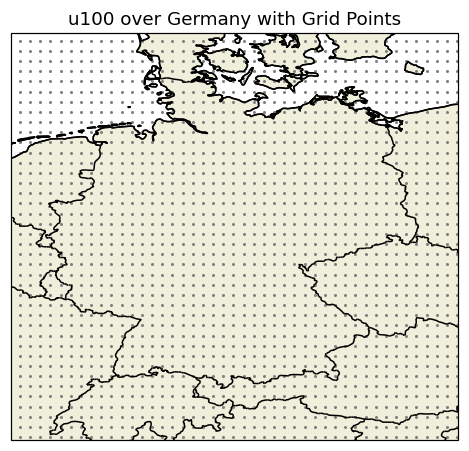

In [1424]:
# Create a figure and axis with cartopy projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([5, 16, 46, 56])  # Extent for Germany

# Plot the data
# data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=True)

# Plot the grid points
ax.scatter(lon, lat, color='grey', s=1, transform=ccrs.PlateCarree())

# Haversine validation ----------
# Plot test turbine location
# ax.scatter([13.901308,], [53.350347,], color='blue', s=3, transform=ccrs.PlateCarree(), marker='*', zorder=2)
# Plot turbine's closest grid point based on results of haversine calcluation
# ax.scatter([13.97,], [53.32,], color='blue', s=1, transform=ccrs.PlateCarree(), zorder=2)
# Hottest grid point representing 458 turbines
# ax.scatter([8.97,], [54.07,], color='red', s=25, transform=ccrs.PlateCarree(), zorder=2)


# Add map features for context
ax.add_feature(cfeature.BORDERS, linestyle='-')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.set_title(f"{data_var} over Germany with Grid Points")

plt.show()

In [1419]:
lat.shape

(42, 52)

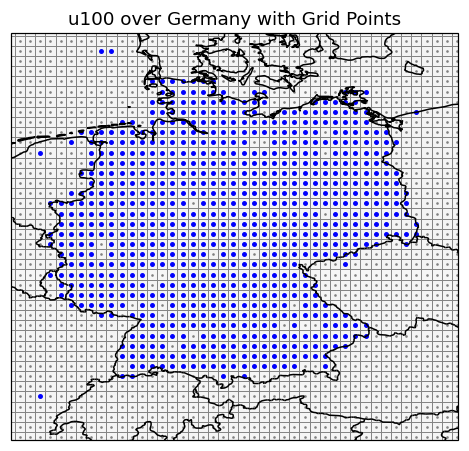

In [1451]:
# Create a figure and axis with cartopy projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([5, 16, 46, 56])  # Extent for Germany

grid_width = np.mean(np.diff(lon[0,:]))
grid_height = np.mean(np.diff(lat[:,0]))


# Draw the grid cells
# for i in range(lon.shape[0] - 1):
#     for j in range(lon.shape[1] - 1):
#         lower_left_x = lon[i, j]
#         lower_left_y = lat[i, j]
#         rect = mpatches.Rectangle((lower_left_x, lower_left_y), grid_width, grid_height,
#                                   facecolor='whitesmoke', edgecolor='grey', linewidth=0.5, transform=ccrs.PlateCarree())
#         ax.add_patch(rect)
        
        
# Draw the grid cells centered on each grid point
for i in range(lon.shape[0]):
    for j in range(lon.shape[1]):
        # Compute the bottom-left corner of the cell
        lower_left_x = lon[i, j] - grid_width / 2
        lower_left_y = lat[i, j] - grid_height / 2
        rect = mpatches.Rectangle((lower_left_x, lower_left_y), grid_width, grid_height,
                                  facecolor='whitesmoke', edgecolor='grey', linewidth=0.6, transform=ccrs.PlateCarree())
        ax.add_patch(rect)
        
        
# Plot the grid points
ax.scatter(lon, lat, color='grey', s=0.5, transform=ccrs.PlateCarree())

# Extract latitudes and longitudes from used_grid_points and plot them
# latitudes = [point[0] for point in used_grid_points]
# longitudes = [point[1] for point in used_grid_points]
# ax.scatter(longitudes, latitudes, color='blue', s=2, transform=ccrs.PlateCarree(), label="Used Grid Points")


# Find the closest grid center for each point in used_grid_points and plot it
for point in used_grid_points:
    # Find the index of the nearest latitude
    idx_lat = np.abs(lat[:, 0] - point[0]).argmin()
    
    # Find the index of the nearest longitude
    idx_lon = np.abs(lon[0, :] - point[1]).argmin()

    # Plot at the grid center
    ax.scatter(lon[idx_lat, idx_lon], lat[idx_lat, idx_lon], color='blue', s=5, transform=ccrs.PlateCarree())



# Add map features for context
ax.add_feature(cfeature.BORDERS, linestyle='-')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.set_title(f"{data_var} over Germany with Grid Points")

# ax.legend(loc='upper right')  # Adds a legend

plt.show()

-----

## Calculating the closest grid point for each turbine
- "When you download ERA5 data, the grid geometry of your output data depends on the selected data format:
    - If you request the data in the native GRIB format it is delivered with the above grid geometry.
    - If you request the data in NetCDF format, _it is automatically converted and interpolated from the above grids to a regular lat/lon grid_."
        - "If you are using a NetCDF file, then your data is in EPSG:4326 geographic coordinates (aka WGS84 projection)"
    - https://confluence.ecmwf.int/display/CKB/ERA5%3A+What+is+the+spatial+reference
- Three possible methods to calculate the nearest grid point
    - Use Haversine distance?
        - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html
        - "determine Great Circle distances between locations (good if your data is in lat/lon format)"
    - KDTree
        - https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html
    - Nearest-neighbor interpolation
        - https://en.wikipedia.org/wiki/Nearest-neighbor_interpolation
        - https://stackoverflow.com/questions/30873844/identifying-the-nearest-grid-point
        - Scipy `scipy.interpolate.RegularGridInterpolator`: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RegularGridInterpolator.html\
- Projected coordinate system (or planar, grid)
    - A standardized cartesian coordinate system that models the Earth (or more commonly, a large region thereof) as a plane, measuring locations from an arbitrary origin point along x and y axes more or less aligned with the cardinal directions

In [121]:
ds.longitude.values

array([ 4.22,  4.47,  4.72,  4.97,  5.22,  5.47,  5.72,  5.97,  6.22,
        6.47,  6.72,  6.97,  7.22,  7.47,  7.72,  7.97,  8.22,  8.47,
        8.72,  8.97,  9.22,  9.47,  9.72,  9.97, 10.22, 10.47, 10.72,
       10.97, 11.22, 11.47, 11.72, 11.97, 12.22, 12.47, 12.72, 12.97,
       13.22, 13.47, 13.72, 13.97, 14.22, 14.47, 14.72, 14.97, 15.22,
       15.47, 15.72, 15.97, 16.22, 16.47, 16.72, 16.97], dtype=float32)

In [68]:
ds.latitude.values

array([56.32, 56.07, 55.82, 55.57, 55.32, 55.07, 54.82, 54.57, 54.32,
       54.07, 53.82, 53.57, 53.32, 53.07, 52.82, 52.57, 52.32, 52.07,
       51.82, 51.57, 51.32, 51.07, 50.82, 50.57, 50.32, 50.07, 49.82,
       49.57, 49.32, 49.07, 48.82, 48.57, 48.32, 48.07, 47.82, 47.57,
       47.32, 47.07, 46.82, 46.57, 46.32, 46.07], dtype=float32)

In [81]:
# Using itertools' product to get all 2,184 coordinate (lat, lon) pairs
list(product(ds.longitude.values, ds.latitude.values))[:5]

[(4.22, 56.32), (4.22, 56.07), (4.22, 55.82), (4.22, 55.57), (4.22, 55.32)]

In [82]:
len(list(product(ds.longitude.values, ds.latitude.values)))

2184

-----

## Test haversine equation
- The first coordinate of each point is assumed to be the latitude, the second is the longitude, given in radians
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html

In [403]:
# Great circle distance should be 474km
# Must use order lat, lon!
bonn = [50.73, 7.09]
berlin = [52.52, 13.41]

# Convert decimal degrees to radians
bonn_in_radians = [radians(decimal_degree) for decimal_degree in bonn]
berlin_in_radians = [radians(decimal_degree) for decimal_degree in berlin]

# Calculate haversine and multiply by Earth radius in km to get distance in km (or radius in m for distance in m)
result = haversine_distances([bonn_in_radians, berlin_in_radians]) * 6371
result

array([[  0.        , 479.31408256],
       [479.31408256,   0.        ]])

In [404]:
# Add additional points
bsas = [-34.83333, -58.5166646]
paris = [49.0083899664, 2.53844117956]
bsas_in_radians = [radians(decimal_degree) for decimal_degree in bsas]
paris_in_radians = [radians(decimal_degree) for decimal_degree in paris]

In [405]:
[bonn_in_radians]

[[0.8854055295367234, 0.12374384396639797]]

#### Calculate distances from X using an array of locations in the 2D array Y

In [406]:
# 2D array (or list inside list) of the point of interest; this will be the turbine location! 
X = [bonn_in_radians]
# The three other locations (this will be the grid points)
Y = [berlin_in_radians, bsas_in_radians, paris_in_radians]

# Calculate distances from Bonn (the point of interest) to the other locations
result = haversine_distances(X, Y)
result_in_km = result * 6371
result_in_km

array([[  479.31408256, 11470.55838348,   378.13054497]])

In [413]:
# Get minimum distance; this will be the closest grid point
closest_distance = result_in_km.min()

# Index of closest distance
idx_closest = np.argmin(result_in_km)

print(f'Distance: {closest_distance} km')
print(idx_closest)
print(grid_points[idx_closest])

Distance: 378.13054497006664 km
2
(56.32, 4.72)


----

## Calculating the nearest grid point for every turbine in dataset
- And adding the nearest grid point as a new column

### Read in turbine data

In [566]:
# Read in latest turbine data
df = pd.read_pickle(data_push_path / 'df_turbines_knn_wrangled.pkl')

In [1228]:
# Cartesian product of grid latitude and longitude values
grid_points = tuple(product(ds.latitude.values, ds.longitude.values))

# Nested list comprehension to convert each decimal degree to radians, creating 2D matrix shape (2184, 2)
grid_points_radians = np.array([[radians(decimal_degree) for decimal_degree in decimal_degree_pair] for decimal_degree_pair in grid_points])

#### Custom function to calculate haversine distances and get nearest grid point

In [570]:
def calc_nearest_grid_point(row, grid_points):
    # turbine lat, lon decimal degrees in list
    turbine_lat_lon = [row.Breitengrad, row.Laengengrad]
    # convert decimal degrees to radians and reshape to 2D array
    turbine_lat_lon_radians = np.array([[radians(decimal_degree) for decimal_degree in turbine_lat_lon]])
    
    # Nested list comprehension to convert each grid point's decimal degree to radians, creating 2D matrix shape (2184, 2)
    grid_points_radians = np.array([[radians(decimal_degree) for decimal_degree in decimal_degree_pair] for decimal_degree_pair in grid_points])
    
    # calculate haversine distances of all grid points from turbine
    # X is the turbine coords in radians as 2D matrix; Y is grid points in radians as 2D matrix
    distances = haversine_distances(turbine_lat_lon_radians, grid_points_radians)
    # multiply by Earth radius in km (6371 km) to get distance in km (or radius in m for distance in m)
    distances_in_km = distances * 6371
    
    # Get shortest distance; this is the closest grid point's distance in km
    shortest_distance = distances_in_km.min()
    # Index of shortest distance
    idx_closest = np.argmin(distances_in_km)
    # Get lat, lon coords of closest grid point by indexing
    nearest_grid_point_to_turbine = grid_points[idx_closest]
    
    # row['nearest_grid_point'] = nearest_grid_point_to_turbine
    
    return nearest_grid_point_to_turbine

In [571]:
# takes c. 1 minute to run
# df['nearest_grid_point'] = df[['Breitengrad', 'Laengengrad']].apply(calc_nearest_grid_point, grid_points=grid_points, axis=1)

In [574]:
# df.loc[10178, ['Breitengrad', 'Laengengrad', 'nearest_grid_point']]

In [575]:
df[['Breitengrad', 'Laengengrad', 'nearest_grid_point']].sample(4)

,Breitengrad,Laengengrad,nearest_grid_point
19507,52.000143,12.839271,"(52.07, 12.72)"
24366,54.034055,12.189490,"(54.07, 12.22)"
24858,51.776701,8.147305,"(51.82, 8.22)"
25776,51.104760,6.430310,"(51.07, 6.47)"


#### Save df as pickle object to save progress

In [498]:
# save df to data to push dir so it lands in GitHub repo
# df.to_pickle(data_push_path / 'df_turbines_knn_blades_haversine.pkl')

-----

### Get array of grid points that are unused
- 2,184 unique coordinate pairs in CDS
- ~758 unique used by turbines~
    - 755 after removing three turbines outside bounding box
- ~1,426 grid points are unused~
    - 1,429 unused after removing three turbines

In [1231]:
# 2,184 coordinate pairs from CDS data bounding box
# 42 latitude x 52 longitude = 2,184
grid_points_set = set(grid_points)
len(grid_points_set)

2184

In [740]:
# create set of tuples
# set(zip(grid_points_array.T[0], grid_points_array.T[1]))

In [1232]:
# Only 755 are nearest points for turbines
# 1,429 grid points are unused out of the 2,184
# 1D array of unique tuples
used_grid_points = np.unique(df['nearest_grid_point'].to_numpy())
used_grid_points.shape

(755,)

#### I can use this set of unused grid points to reduce the xarray dataset size

In [1233]:
# Set of used grid points; also 758 since all are unique
# I can use these to reduce xarray dataset size! 

# cast array as set
grid_points_used_set = set(used_grid_points)
len(grid_points_used_set)

755

In [1234]:
# Set of 1,429 unused grid points
unused_grid_points = grid_points_set.difference(grid_points_used_set)
len(unused_grid_points)

1429

In [1181]:
len(grid_points_set.union(grid_points_used_set))

2184

In [745]:
# vertical stack the used grid points and reshape
# used_grid_points_2d = np.vstack(np.unique(df['nearest_grid_point'].to_numpy())).reshape(758, 2)
# used_grid_points_2d

In [642]:
# access the 2184 latitudes
np.array(grid_points)[:,0]

array([56.32, 56.32, 56.32, ..., 46.07, 46.07, 46.07], dtype=float32)

In [683]:
# access the 2184 longitudes
np.array(grid_points)[:,1]

array([ 4.22,  4.47,  4.72, ..., 16.47, 16.72, 16.97], dtype=float32)

-----

## Add elevation data for each of the 758 used grid points (and for all turbine locations)
- Use Open-Elevation. It's a free and open-source alternative to the Google Elevation API and similar offerings
    - https://github.com/Jorl17/open-elevation
    - https://open-elevation.com/

#### Function that fetches elevation data from Open-Elevation

In [950]:
url_endpoint = "https://api.open-elevation.com/api/v1/lookup"

def fetch_elevation_data(coordinates):
    """
    Fetch elevations for list of coordinates in lat, lon tuples
    """
    # Format coordinates according to Open-Elevation requirements
    # Lat and lons are type float32 (not JSON serializable); cast to Python float64
    grid_point_locations = [{"latitude": float(lat), "longitude": float(lon)} for lat, lon in coordinates]
    # Make POST request
    response = requests.post(url_endpoint, json={"locations": grid_point_locations})
    if response.status_code == 200:  
        # Decode JSON response object to Python dict
        datadict = response.json()
        # Return decoded object as dict
        return datadict
    else:
        return print(f'Request failed with status code: {response.status_code}')

In [837]:
# list of lat,lon tuples -> (47.07, 5.72)
# Careful: this gives values of type numpy.float32 with is not JSON serializable!
coordinates_needing_elevation = used_grid_points.tolist()

#### Call function and fetch data via API

In [838]:
# Call function to fetch elevation data
# elevation_datadict = fetch_elevation_data(coordinates_needing_elevation)

##### Construct dataframe using response data

In [887]:
# load datadict results into dataframe
df_elevations = pd.DataFrame(elevation_datadict['results'])
df_elevations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 758 entries, 0 to 757
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   758 non-null    float64
 1   longitude  758 non-null    float64
 2   elevation  758 non-null    float64
dtypes: float64(3)
memory usage: 17.9 KB


In [888]:
# create new column with coordinates as tuples of lat, lon casted as float32 to match dtype in df
df_elevations['nearest_grid_point'] = df_elevations.apply(lambda row: (np.float32(row.latitude), np.float32(row.longitude)), axis=1)
df_elevations.head()

,latitude,longitude,elevation,nearest_grid_point
0,47.07,5.72,256.0,"(47.07, 5.72)"
1,47.57,7.72,506.0,"(47.57, 7.72)"
2,47.57,7.97,435.0,"(47.57, 7.97)"
3,47.57,10.22,833.0,"(47.57, 10.22)"
4,47.57,10.72,798.0,"(47.57, 10.72)"


In [899]:
# tuple objects are equal
df_elevations['nearest_grid_point'].isin(df['nearest_grid_point']).value_counts()

nearest_grid_point
True    758
Name: count, dtype: int64

In [892]:
type(df['nearest_grid_point'].to_list()[0][0])

numpy.float32

In [893]:
type(df_elevations['nearest_grid_point'].to_list()[0][0])

numpy.float32

In [898]:
# Check that there's no difference between the two sets
elevation_set = set(df_elevations['nearest_grid_point'].to_list())
print(elevation_set.difference(grid_points_used_set))
print(grid_points_used_set.difference(elevation_set))

set()
set()


#### Merge elevation into main `df` using key `nearest_grid_point`

In [906]:
# use different variable name df_merged so that I can test against df
df_merged = df.merge(df_elevations[['nearest_grid_point', 'elevation']], how='left', left_on='nearest_grid_point', right_on='nearest_grid_point')

In [932]:
(df_merged['nearest_grid_point'] == df['nearest_grid_point']).value_counts()

nearest_grid_point
True    30645
Name: count, dtype: int64

-----

### Also add elevation data for all 30,645 turbines!

In [958]:
# Split the turbine coordinates into two arrays so request to API is not too large for server to handle
turbine_coords_list_1, turbine_coords_list_2 = np.array_split(df[['Breitengrad', 'Laengengrad']].apply(
    lambda row: (row.Breitengrad, row.Laengengrad), axis=1).to_numpy(), 2)

In [970]:
# Fetch elevation data
turbine_elevation_datadict_1 = fetch_elevation_data(turbine_coords_list_1)
turbine_elevation_datadict_2 = fetch_elevation_data(turbine_coords_list_2)

In [973]:
# Extend the first list with the second list of elevation data
turbine_elevation_datadict_1['results'].extend(turbine_elevation_datadict_2['results'])

In [980]:
len(turbine_elevation_datadict_1['results'])

30645

In [981]:
# load datadict results into dataframe
df_turbine_elevations = pd.DataFrame(turbine_elevation_datadict_1['results'])
df_turbine_elevations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30645 entries, 0 to 30644
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   30645 non-null  float64
 1   longitude  30645 non-null  float64
 2   elevation  30645 non-null  float64
dtypes: float64(3)
memory usage: 718.4 KB


In [984]:
# rename column
df_turbine_elevations.rename(columns={'elevation': 'turbine_elevation'}, inplace=True)

In [1015]:
# Check that lat and lons line up correctly on index
# df.merge(df_turbine_elevations, how='left', left_index=True, right_index=True)[['Breitengrad', 'Laengengrad', 'latitude', 'longitude', 'turbine_elevation_y']].sample(10)

In [988]:
# Merge the turbine elevation data to the main df, merging on index
df = df.merge(df_turbine_elevations[['turbine_elevation']], how='left', left_index=True, right_index=True)

In [991]:
# rename elevation column
df.rename(columns={'elevation': 'nearest_grid_point_elevation'}, inplace=True)

In [993]:
# rename elevation column
df.rename(columns={'nearest_gridpoint_elevation': 'nearest_grid_point_elevation'}, inplace=True)

In [1001]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30645 entries, 0 to 30644
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   EinheitMastrNummer                     30645 non-null  object        
 1   DatumLetzteAktualisierung              30645 non-null  datetime64[ns]
 2   Bundesland                             30645 non-null  object        
 3   Postleitzahl                           30645 non-null  int64         
 4   Ort                                    30645 non-null  object        
 5   Laengengrad                            30645 non-null  float64       
 6   Breitengrad                            30645 non-null  float64       
 7   Registrierungsdatum                    30645 non-null  datetime64[ns]
 8   Inbetriebnahmedatum                    30645 non-null  datetime64[ns]
 9   EinheitBetriebsstatus                  30645 non-null  object

-----

### Also add distance from turbine to nearest grid point

In [1006]:
def calc_nearest_grid_point_distance(row, grid_points):
    # turbine lat, lon decimal degrees in list
    turbine_lat_lon = [row.Breitengrad, row.Laengengrad]
    # convert decimal degrees to radians and reshape to 2D array
    turbine_lat_lon_radians = np.array([[radians(decimal_degree) for decimal_degree in turbine_lat_lon]])
    
    # Nested list comprehension to convert each grid point's decimal degree to radians, creating 2D matrix shape (2184, 2)
    grid_points_radians = np.array([[radians(decimal_degree) for decimal_degree in decimal_degree_pair] for decimal_degree_pair in grid_points])
    
    # calculate haversine distances of all grid points from turbine
    # X is the turbine coords in radians as 2D matrix; Y is grid points in radians as 2D matrix
    distances = haversine_distances(turbine_lat_lon_radians, grid_points_radians)
    # multiply by Earth radius in km (6371 km) to get distance in km (or radius in m for distance in m)
    distances_in_km = distances * 6371
    
    # Get shortest distance; this is the closest grid point's distance in km
    shortest_distance = distances_in_km.min()
    
    return shortest_distance

In [1007]:
# takes c. 1 minute to run
df['nearest_grid_point_distance'] = df[['Breitengrad', 'Laengengrad']].apply(
    calc_nearest_grid_point_distance, grid_points=grid_points, axis=1)

In [1016]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30645 entries, 0 to 30644
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   EinheitMastrNummer                     30645 non-null  object        
 1   DatumLetzteAktualisierung              30645 non-null  datetime64[ns]
 2   Bundesland                             30645 non-null  object        
 3   Postleitzahl                           30645 non-null  int64         
 4   Ort                                    30645 non-null  object        
 5   Laengengrad                            30645 non-null  float64       
 6   Breitengrad                            30645 non-null  float64       
 7   Registrierungsdatum                    30645 non-null  datetime64[ns]
 8   Inbetriebnahmedatum                    30645 non-null  datetime64[ns]
 9   EinheitBetriebsstatus                  30645 non-null  object

In [1010]:
df[['nearest_grid_point', 'nearest_grid_point_elevation', 'turbine_elevation', 'nearest_grid_point_distance']].sample(10)

,nearest_grid_point,nearest_grid_point_elevation,turbine_elevation,nearest_grid_point_distance
12958,"(54.82, 9.22)",30.0,11.0,8.859032
14743,"(54.07, 10.22)",40.0,47.0,5.952269
12634,"(53.57, 13.47)",71.0,16.0,13.804135
15088,"(51.57, 13.22)",87.0,118.0,13.742291
5004,"(52.32, 13.47)",38.0,69.0,12.220403
1625,"(52.32, 7.72)",105.0,42.0,12.868752
30575,"(52.82, 9.22)",27.0,13.0,5.542664
18367,"(54.57, 9.22)",22.0,13.0,13.065521
3695,"(50.82, 12.72)",485.0,282.0,12.615963
25732,"(51.82, 11.97)",53.0,71.0,7.739482


In [1022]:
df[['nearest_grid_point_elevation', 'turbine_elevation', 'nearest_grid_point_distance']].describe()

,nearest_grid_point_elevation,turbine_elevation,nearest_grid_point_distance
count,30645.000000,30645.000000,30645.000000
mean,143.741491,156.241997,8.822684
std,172.404787,186.707268,5.264850
min,-3.000000,-52.000000,0.024881
25%,24.000000,25.000000,6.223402
50%,66.000000,69.000000,8.765016
75%,216.000000,267.000000,11.568235
max,1080.000000,1296.000000,569.503887


In [1048]:
# df[df['turbine_elevation'] < 0]

-----

#### Remove the 3 turbines with coordinates outside bounding box (by checking anomalies in distance to nearest grid point)
- SEE956234354696 is in Norway according to coords given
- SEE908329152380 is near English Channel off the coast of France
- SEE919842697579 is in middle of the North Sea

#### Update: I also removed 4 more turbines that were clearly situated outside of Germany (likely incorrect coordinates in turbine dataset)

In [1032]:
# Only three turbines are more than 17km from a grid point in bounding box
df[df['nearest_grid_point_distance'] > 17]

,EinheitMastrNummer,DatumLetzteAktualisierung,Bundesland,Postleitzahl,Ort,Laengengrad,Breitengrad,Registrierungsdatum,Inbetriebnahmedatum,EinheitBetriebsstatus,DatumEndgueltigeStilllegung,DatumBeginnVoruebergehendeStilllegung,DatumWiederaufnahmeBetrieb,NameStromerzeugungseinheit,Nettonennleistung,AnschlussAnHoechstOderHochSpannung,Einspeisungsart,NameWindpark,Hersteller,Technologie,Typenbezeichnung,Nabenhoehe,Rotordurchmesser,Rotorblattenteisungssystem,area_blades,nearest_grid_point,nearest_grid_point_elevation,turbine_elevation,nearest_grid_point_distance
288,SEE956234354696,2022-12-01 07:52:10.180000000,Nordrhein-Westfalen,33100,Paderborn,8.833742,60.003844,2019-02-06,2001-07-25,Endgültig stillgelegt,2021-07-15,NaT,NaT,Anemos,1500.0,0.0,Volleinspeisung,None,ENERCON GmbH,Horizontalläufer,E-66,66.8,66.0,NaN,3421,"(56.32, 8.72)",41.0,0.0,409.678963
2353,SEE908329152380,2021-04-08 05:53:22.179348700,Rheinland-Pfalz,54497,Morbach,-3.622044,49.142675,2019-03-18,2003-02-06,Endgültig stillgelegt,2019-02-26,NaT,NaT,16372,2000.0,0.0,Volleinspeisung,Energielandschaft Morbach,Vestas Deutschland GmbH,Horizontalläufer,V80,100.0,80.0,NaN,5026,"(49.32, 4.22)",104.0,0.0,569.503887
6331,SEE919842697579,2022-04-28 15:04:47.325487400,Schleswig-Holstein,24969,Lindewitt,3.168577,54.688393,2019-06-28,2001-12-21,Endgültig stillgelegt,2021-12-31,NaT,NaT,Lola 14516,660.0,NaN,Volleinspeisung,Windpark Sillerup,Vestas Deutschland GmbH,Horizontalläufer,Vestas V47-660 KW,65.0,47.0,0.0,1734,"(54.57, 4.22)",0.0,0.0,68.944694


In [1037]:
remove_these_idxs = df[df['nearest_grid_point_distance'] > 17].index
remove_these_idxs

Index([288, 2353, 6331], dtype='int64')

In [1040]:
df.drop(index=remove_these_idxs, axis='index', inplace=True)

In [1044]:
df.reset_index(drop=True, inplace=True)

-----

### Check for anomalies in difference in turbine and grid point elevations
- 3,108 of the 30,642 (10%) turbines have a relative height difference to nearest grid point of more than or equal to 100m
- 614 of the 30,642 (2%) more than or equal to 200m
- 138 more than or equal to 300m

#### Interpolation ideas
- Definitely take this relative height difference into account and interpolate
    - Interpolate using wind profile power law: https://en.wikipedia.org/wiki/Wind_profile_power_law

In [1057]:
# Create new column of differences between turbine elevation and nearest grid point elevation
df['turbine_elevation_relative_to_nearest_grid_point'] = df[['turbine_elevation', 'nearest_grid_point_elevation']].apply(
    lambda row: row.turbine_elevation - row.nearest_grid_point_elevation, axis=1)

In [1063]:
df.sample(3)

,EinheitMastrNummer,DatumLetzteAktualisierung,Bundesland,Postleitzahl,Ort,Laengengrad,Breitengrad,Registrierungsdatum,Inbetriebnahmedatum,EinheitBetriebsstatus,DatumEndgueltigeStilllegung,DatumBeginnVoruebergehendeStilllegung,DatumWiederaufnahmeBetrieb,NameStromerzeugungseinheit,Nettonennleistung,AnschlussAnHoechstOderHochSpannung,Einspeisungsart,NameWindpark,Hersteller,Technologie,Typenbezeichnung,Nabenhoehe,Rotordurchmesser,Rotorblattenteisungssystem,area_blades,nearest_grid_point,nearest_grid_point_elevation,turbine_elevation,nearest_grid_point_distance,turbine_elevation_relative_to_nearest_grid_point
12743,SEE914798442099,2021-10-27 13:25:13.931063700,Rheinland-Pfalz,54597,Ormont,6.462373,50.339966,2019-12-18,2005-06-23,In Betrieb,NaT,NaT,NaT,NX-70300,1500.0,1.0,Volleinspeisung,WP Eifel,Nordex SE,Horizontalläufer,S-70,65.0,70.0,0.0,3848,"(50.32, 6.47)",639.0,597.0,2.285204,-42.0
30312,SEE947259295996,2023-07-27 09:47:15.267895800,Schleswig-Holstein,25899,Niebüll,8.780344,54.796244,2023-06-15,2023-06-13,In Betrieb,NaT,NaT,NaT,T02-90894,3600.0,NaN,Volleinspeisung,T02-90894,Nordex SE,Horizontalläufer,N117/3600 STE,91.0,116.8,0.0,10714,"(54.82, 8.72)",-1.0,-3.0,4.683114,-2.0
29943,SEE905045444737,2023-06-29 10:30:42.728970300,Sachsen-Anhalt,39606,Osterburg,11.814733,52.746248,2023-06-29,2023-06-15,In Betrieb,NaT,NaT,NaT,Düsedau II WEA 4,5600.0,NaN,Teileinspeisung (einschließlich Eigenverbrauch),Windpark Düsedau II,Vestas Deutschland GmbH,Horizontalläufer,V 150-5.6,169.0,150.0,0.0,17671,"(52.82, 11.72)",71.0,31.0,10.384867,-40.0


In [1067]:
df[(df['turbine_elevation'] == 0) & (df['nearest_grid_point_elevation'] != 0)]['turbine_elevation_relative_to_nearest_grid_point'].describe()

count    234.000000
mean      -5.333333
std       10.674264
min      -44.000000
25%       -8.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: turbine_elevation_relative_to_nearest_grid_point, dtype: float64

In [1074]:
# df[(df['turbine_elevation'] == 0) & (df['nearest_grid_point_elevation'] != 0) & (df['turbine_elevation_relative_to_nearest_grid_point'] < -20)]

In [1087]:
df[(df['turbine_elevation_relative_to_nearest_grid_point'].abs() >= 300)]

,EinheitMastrNummer,DatumLetzteAktualisierung,Bundesland,Postleitzahl,Ort,Laengengrad,Breitengrad,Registrierungsdatum,Inbetriebnahmedatum,EinheitBetriebsstatus,DatumEndgueltigeStilllegung,DatumBeginnVoruebergehendeStilllegung,DatumWiederaufnahmeBetrieb,NameStromerzeugungseinheit,Nettonennleistung,AnschlussAnHoechstOderHochSpannung,Einspeisungsart,NameWindpark,Hersteller,Technologie,Typenbezeichnung,Nabenhoehe,Rotordurchmesser,Rotorblattenteisungssystem,area_blades,nearest_grid_point,nearest_grid_point_elevation,turbine_elevation,nearest_grid_point_distance,turbine_elevation_relative_to_nearest_grid_point
21,SEE964274163000,2022-08-23 08:27:44.047409500,Baden-Württemberg,78132,Hornberg,8.255743,48.233353,2019-02-05,2002-12-20,In Betrieb,NaT,NaT,NaT,FL1000 Nr.:254,1000.0,0.0,Volleinspeisung,Reichenbach,Fuhrländer AG,Horizontalläufer,FL 1000,110.00,54.0,0.0,2290,"(48.32, 8.22)",344.0,823.0,9.991171,479.0
75,SEE919985691250,2021-01-26 08:32:47.355736400,Baden-Württemberg,77887,Sasbachwalden,8.201761,48.607354,2019-02-04,2015-11-06,In Betrieb,NaT,NaT,NaT,Hornisgrinde 1,2300.0,0.0,Volleinspeisung,Windpark Hornisgrinde,ENERCON GmbH,Horizontalläufer,E-70 E4,84.40,71.0,NaN,3959,"(48.57, 8.22)",756.0,1154.0,4.364875,398.0
79,SEE974457797076,2021-06-09 09:36:43.634206100,Hessen,35759,Driedorf,8.126357,50.648611,2019-02-04,2014-03-16,In Betrieb,NaT,NaT,NaT,E-101,3050.0,0.0,Volleinspeisung,Driedorf-Hohenroth,ENERCON GmbH,Horizontalläufer,E-101,149.00,101.0,NaN,8011,"(50.57, 8.22)",296.0,616.0,10.957774,320.0
87,SEE994680864611,2020-03-10 07:10:16.288056700,Hessen,35759,Driedorf,8.136672,50.651746,2019-02-04,2009-01-23,In Betrieb,NaT,NaT,NaT,E-53,800.0,NaN,Volleinspeisung,Driedorf-Waldaubach,ENERCON GmbH,Horizontalläufer,E-53,73.25,52.9,NaN,2197,"(50.57, 8.22)",296.0,606.0,10.825739,310.0
112,SEE913798001084,2023-05-19 14:35:39.717752700,Hessen,35759,Driedorf,8.132222,50.647178,2019-02-04,2006-01-10,In Betrieb,NaT,NaT,NaT,E-48,800.0,NaN,Volleinspeisung,Driedorf-Hohenroth,ENERCON GmbH,Horizontalläufer,E-48,75.60,48.0,NaN,1809,"(50.57, 8.22)",296.0,623.0,10.583734,327.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29192,SEE963403306219,2022-10-30 06:04:43.753261400,Baden-Württemberg,79263,Simonswald,8.081200,48.048988,2021-01-26,2000-11-28,In Betrieb,NaT,NaT,NaT,Simonswald 2,1000.0,0.0,Volleinspeisung,Windpark Simonswald Platte,NEG Micon Deutschland GmbH,Horizontalläufer,NEG Micon NM 60/1000,70.00,60.0,0.0,2827,"(48.07, 7.97)",627.0,1003.0,8.588102,376.0
29197,SEE915647960467,2022-10-30 06:04:45.791164700,Baden-Württemberg,79263,Simonswald,8.084100,48.047907,2021-01-26,2000-11-28,In Betrieb,NaT,NaT,NaT,Simonswald 3,1000.0,0.0,Volleinspeisung,Windpark Simonswald Platte,NEG Micon Deutschland GmbH,Horizontalläufer,NEG Micon NM 60/1000,70.00,60.0,0.0,2827,"(48.07, 7.97)",627.0,993.0,8.828466,366.0
30324,SEE952786118731,2021-11-03 16:26:46.437311100,Bayern,94259,Kirchberg i.Wald,13.182189,48.898100,2021-10-20,2014-01-28,In Betrieb,NaT,NaT,NaT,Black600,0.5,NaN,Volleinspeisung,Black600,Sonstige,Horizontalläufer,Black600,10.00,1.2,0.0,1,"(48.82, 13.22)",985.0,662.0,9.114216,-323.0
30465,SEE926676935678,2022-09-12 10:54:21.278929400,Baden-Württemberg,77728,Oppenau,8.162125,48.471978,2022-02-09,2022-02-09,In Betrieb,NaT,NaT,NaT,Herlesries III,2.0,NaN,Teileinspeisung (einschließlich Eigenverbrauch),Herlesries III,SkyWind GmbH,Horizontalläufer,SkyWind NG 1kW,6.00,1.5,0.0,1,"(48.57, 8.22)",756.0,272.0,11.703288,-484.0


In [1086]:
df['turbine_elevation_relative_to_nearest_grid_point'].describe()

count    30642.000000
mean        12.506462
std         62.185300
min       -484.000000
25%        -10.000000
50%          1.000000
75%         24.000000
max        574.000000
Name: turbine_elevation_relative_to_nearest_grid_point, dtype: float64

----

## Calculate 10m mean wind speed using 10m u and v components in xarray dataset and add as new variable
- `Dataset.map` vs `xr.apply_ufunc()`?
- Use the latter!

#### Helper function to calculate wind speed using zonal and meridional components

In [1165]:
def calc_wind_speed_using_ortho_components(u_zonal, v_meridional):
    """
    u_zondal (u10): wind component along local parallel of latitude; positive from west, negative from east
    v_meridional (v10): wind component along local meridian; positive from south, negative from north
    """
    # use numpy.sqrt() as math.sqrt() only accepts scalar value not array
    mean_wind_speed = np.sqrt(u_zonal**2 + v_meridional**2)
    return mean_wind_speed

In [1177]:
# Apply the calc wind speed function and assign to dataset as a new data variable 
ds['mean_wind_speed'] = xr.apply_ufunc(calc_wind_speed_using_ortho_components, ds['u10'], ds['v10'])

In [1178]:
ds.data_vars

Data variables:
    u100             (time, latitude, longitude) float32 ...
    v100             (time, latitude, longitude) float32 ...
    u10              (time, latitude, longitude) float32 9.286 9.145 ... 3.102
    v10              (time, latitude, longitude) float32 1.064 0.9334 ... 3.552
    mean_wind_speed  (time, latitude, longitude) float32 9.347 9.192 ... 4.716

In [1180]:
ds['mean_wind_speed']

<xarray.DataArray 'mean_wind_speed' (time: 8760, latitude: 42, longitude: 52)>
array([[[ 9.347219  ,  9.192375  ,  9.072466  , ...,  7.50117   ,
          8.433682  ,  8.851389  ],
        [ 9.827524  ,  9.8772    ,  9.94721   , ...,  8.965166  ,
          9.210565  ,  9.408081  ],
        [ 9.713647  ,  9.91767   , 10.113175  , ...,  9.23195   ,
          9.393141  ,  9.475513  ],
        ...,
        [ 1.5131553 ,  1.0412627 ,  0.6564507 , ...,  2.7429745 ,
          2.8253496 ,  2.5757082 ],
        [ 1.8003031 ,  1.3810029 ,  0.96155584, ...,  2.955229  ,
          2.654683  ,  2.2551801 ],
        [ 1.538738  ,  1.1251078 ,  0.86823964, ...,  2.555642  ,
          2.3145292 ,  1.994237  ]],

       [[ 8.650046  ,  8.7822695 ,  8.901083  , ...,  7.616774  ,
          8.741889  ,  9.329976  ],
        [ 8.727282  ,  8.933414  ,  9.227422  , ...,  9.176747  ,
          9.588019  ,  9.868747  ],
        [ 8.729724  ,  8.913882  ,  9.169407  , ...,  9.592461  ,
          9.852736  ,  9.943362  ],
...
        [ 5.298374  ,  5.563996  ,  5.892512  , ...,  4.44187   ,
          4.7760773 ,  4.901371  ],
        [ 5.447678  ,  5.599142  ,  6.0077643 , ...,  4.8745456 ,
          4.889312  ,  4.846607  ],
        [ 5.1856184 ,  5.3332477 ,  5.9884295 , ...,  4.388668  ,
          4.569925  ,  4.535411  ]],

       [[ 5.8747945 ,  5.821379  ,  5.7897635 , ...,  7.538751  ,
          8.734823  ,  9.434285  ],
        [ 6.5103292 ,  6.382969  ,  6.275388  , ...,  9.363925  ,
          9.612691  ,  9.936193  ],
        [ 6.9755397 ,  6.8091903 ,  6.7041078 , ...,  9.451603  ,
          9.590656  ,  9.685236  ],
        ...,
        [ 5.21237   ,  5.4045196 ,  5.6885276 , ...,  4.5612116 ,
          4.9248466 ,  5.087913  ],
        [ 5.516361  ,  5.550192  ,  5.9452343 , ...,  4.9847884 ,
          5.0202312 ,  5.0084453 ],
        [ 5.351844  ,  5.486629  ,  6.133389  , ...,  4.479527  ,
          4.713412  ,  4.71563   ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 4.22 4.47 4.72 4.97 ... 16.47 16.72 16.97
  * latitude   (latitude) float32 56.32 56.07 55.82 55.57 ... 46.57 46.32 46.07
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:00:00

----

## Drop all unused grid points (lons and lats) from Xarray Dataset
### Or of course I can just select what I want to KEEP using `ds.sel()`
- lons and lats are separate coordinates
- https://docs.xarray.dev/en/latest/user-guide/indexing.html

#### Selecting data using Dataset indexing on labelled coordinates

In [1215]:
# This returns all data variables for this grid point for the specified day in the time dimension 
ds.sel(time="2022-01-01", latitude=56.32, longitude=4.22)

# Can also provide iterables like lists to coord name for selection
# ds.sel(time="2022-01-01", latitude=[56.32, 56.07], longitude=4.22)

<xarray.Dataset>
Dimensions:          (latitude: 1, time: 24)
Coordinates:
    longitude        float32 4.22
  * latitude         (latitude) float32 56.32
  * time             (time) datetime64[ns] 2022-01-01 ... 2022-01-01T23:00:00
Data variables:
    u100             (time, latitude) float32 ...
    v100             (time, latitude) float32 ...
    u10              (time, latitude) float32 9.286 8.65 6.879 ... 7.535 8.402
    v10              (time, latitude) float32 1.064 0.06851 ... 7.742 7.011
    mean_wind_speed  (time, latitude) float32 9.347 8.65 6.879 ... 10.8 10.94
Attributes:
    Conventions:  CF-1.6
    history:      2023-08-27 18:02:49 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [1274]:
# ds.sel(latitude=[56.32, 52.82], longitude=[4.22, 16.97])

#### Note: the individual lats and lons arrays should NOT be length 755!
- They should be unique
- Lat array is (32,)
- Lon arry is (38,)
- But 32*38 = 1,216 and NOT 755 unique pairs? Solve this

### A few used grid points clearly lie outside of Germany. Remove these turbines. They appear to have incorrect coordinate data 
- Two turbines at latitude 55.57
- Two turbines at longitude 5.72

In [1480]:
lat_series = df['nearest_grid_point'].apply(lambda x: x[0])
lat_series

0        51.32
1        54.07
2        51.32
3        51.32
4        51.07
         ...  
30637    53.57
30638    52.07
30639    54.07
30640    52.57
30641    54.57
Name: nearest_grid_point, Length: 30642, dtype: float32

In [1481]:
lat_series.loc[lat_series > 54.83]

3079     55.57
29763    55.57
Name: nearest_grid_point, dtype: float32

In [1482]:
lon_series = df['nearest_grid_point'].apply(lambda x: x[1])
lon_series

0         9.72
1        10.22
2         9.72
3         9.72
4         5.97
         ...  
30637     7.47
30638     8.97
30639    11.72
30640    13.97
30641     9.22
Name: nearest_grid_point, Length: 30642, dtype: float32

In [1486]:
lon_series.loc[lon_series < 5.8]

26572    5.72
30533    5.72
Name: nearest_grid_point, dtype: float32

In [1374]:
# Only 755 coordinate pairs are nearest points for turbines
# 1,429 grid points are unused out of the 2,184
# 1D array of unique tuples (representing coordinate pairs)
used_grid_points = np.unique(df['nearest_grid_point'].to_numpy())
used_grid_points.shape

(755,)

In [1434]:
used_grid_points.shape

(755,)

In [1487]:
# used_grid_points

In [1279]:
# Since array is 1D I need to split out the first and second elements in each tuple
lats_used = np.unique(np.array([tup[0] for tup in used_grid_points]))
lons_used = np.unique(np.array([tup[1] for tup in used_grid_points]))

In [1488]:
# set(np.array([tup[0] for tup in used_grid_points]))

In [1280]:
lats_used.shape

(32,)

In [1277]:
lats_used

array([47.07, 47.57, 47.82, 48.07, 48.32, 48.57, 48.82, 49.07, 49.32,
       49.57, 49.82, 50.07, 50.32, 50.57, 50.82, 51.07, 51.32, 51.57,
       51.82, 52.07, 52.32, 52.57, 52.82, 53.07, 53.32, 53.57, 53.82,
       54.07, 54.32, 54.57, 54.82, 55.57], dtype=float32)

In [1265]:
lons_used.shape

(38,)

#### ~The below works!~ But it also takes about a minute to run!
- Not what I want! 
    - This resulted in me having 755 longitude and 755 latitude instead of the 52 and 42!
    - Data vars u100 and v100 now have almost 5 billion values instead of the original 19 million!
    - Don't do this `ds.sel(latitude=lats_used, longitude=lons_used)`
    - This probably interpolated all the data vars for all the additional coords!

# ~Now it works~ ~Nope still not what I want~ No, this is fine; let's go with this!
- I end up with 1,216 unique pairs of coords instead of the 755 I need! (original is 2,184)
- Data var count went from c. 19 million to c. 11 million

In [1273]:
ds_subset = ds.sel(latitude=lats_used, longitude=lons_used)
ds_subset

<xarray.Dataset>
Dimensions:          (longitude: 38, latitude: 32, time: 8760)
Coordinates:
  * longitude        (longitude) float32 5.72 5.97 6.22 ... 14.47 14.72 14.97
  * latitude         (latitude) float32 47.07 47.57 47.82 ... 54.57 54.82 55.57
  * time             (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:00:00
Data variables:
    u100             (time, latitude, longitude) float32 ...
    v100             (time, latitude, longitude) float32 ...
    u10              (time, latitude, longitude) float32 -0.7764 ... 6.626
    v10              (time, latitude, longitude) float32 1.997 1.937 ... 4.959
    mean_wind_speed  (time, latitude, longitude) float32 2.143 2.081 ... 8.276
Attributes:
    Conventions:  CF-1.6
    history:      2023-08-27 18:02:49 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [1286]:
ds_subset.latitude

<xarray.DataArray 'latitude' (latitude: 32)>
array([47.07, 47.57, 47.82, 48.07, 48.32, 48.57, 48.82, 49.07, 49.32, 49.57,
       49.82, 50.07, 50.32, 50.57, 50.82, 51.07, 51.32, 51.57, 51.82, 52.07,
       52.32, 52.57, 52.82, 53.07, 53.32, 53.57, 53.82, 54.07, 54.32, 54.57,
       54.82, 55.57], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 47.07 47.57 47.82 48.07 ... 54.57 54.82 55.57

In [1288]:
# Cartesian product of grid latitude and longitude values
new_grid_points = tuple(product(ds_subset.latitude.values, ds_subset.longitude.values))
len(new_grid_points)

1216

In [1289]:
new_grid_points_set = set(new_grid_points)

In [1291]:
# cast array as set
grid_points_used_set = set(used_grid_points)
len(grid_points_used_set)

755

In [1293]:
# Set of 461 unused grid points
new_unused_grid_points = new_grid_points_set.difference(grid_points_used_set)
len(new_unused_grid_points)

461

In [1372]:
# new_unused_grid_points

In [1270]:
ds['u10'].count()

<xarray.DataArray 'u10' ()>
array(19131840)

---

## Extrapolating 10m wind speed to hub height using wind power law and elevations and relative elevation
- "The implications of using the power law to extrapolate winds from 10 m instead of the vertical interpolation of wind speed from model levels are discussed later in the paper"
- "The value of 1/7 for α is commonly assumed to be constant in wind resource assessments, because the differences between the two levels are not usually so great as to introduce substantial errors into the estimates (usually < 50 m). However, when a constant exponent is used, it does not account for the roughness of the surface, the displacement of calm winds from the surface due to the presence of obstacles (i.e., zero-plane displacement), or the stability of the atmosphere"

#### ERA5 'above the earth surface' 10m wind
- "To clarify further, the 10m wind components in ERA5 (and similarly in many other meteorological datasets) represent the wind speeds and directions 10 meters above the "displacement height", which is essentially the effective ground level when considering things like vegetation. For example, over an open ocean, the 10m wind would be 10m above the sea surface. Over a forested area, the reference point might be somewhere within the canopy, so the actual height above the ground could be greater than 10m, but it's effectively 10m above the 'aerodynamic surface' of the forest.

This isn't a measurement from 10 meters above mean sea level (MSL). Instead, it's a reference height above the local ground or water surface. This is an important distinction, especially when considering wind data over varying terrains."

<Axes: >

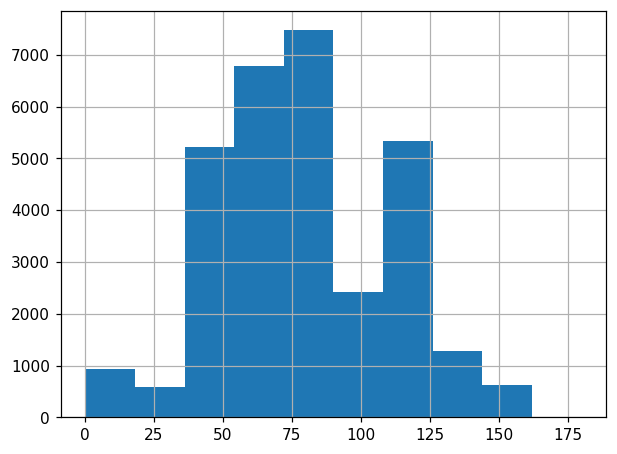

In [1106]:
df['Rotordurchmesser'].hist()

<Axes: >

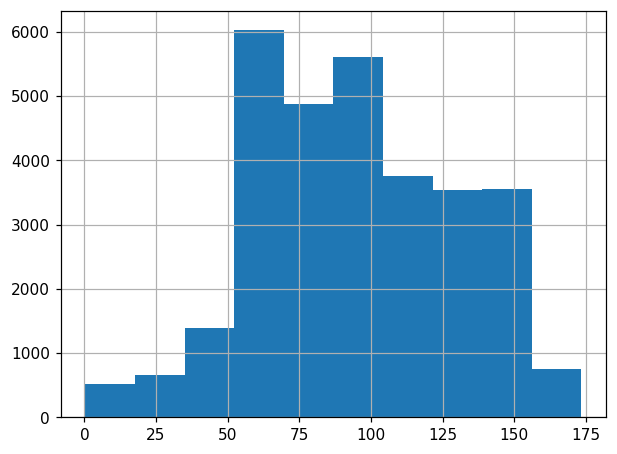

In [1100]:
df['Nabenhoehe'].hist()

### Extrapolate 10m wind speed to hub height using wind power law equation
- The power law exponent (E or alpha) is also called the Höhenwindexponent (Hellmann-Exponent)
    - E varies temporally and spatially, and also depends on atmospheric stability; but often used as a constant of 0.14 for approximations
        - "DerHöhenexponent ist abhängig von der Rauhigkeit, der Höhe und der Gelände struktur"
        - Often we assume neutral or near-neutral atmosphere stability conditions for approximations that don't need to be super precice
    - Germany uses a value of 0.25 for approxminations (see Referenzertrag (reference yield): https://de.wikipedia.org/wiki/Referenzertrag)
        - "The reference yield is a type-specific performance indicator for wind turbines. According to the Renewable Energy Sources Act (EEG), it is defined as "the amount of electricity determined for each type of wind turbine, including the respective hub height, which this type would generate in five years of operation if erected at the reference site on the basis of a measured performance curve."
    - Great resource showing table of E values and landscape descriptions: https://shef-eco-energy.com/ee-grundlagen/windenergieanlagen/windverhaltnisse/
        - Wasserflächen : Meer und Seen: 0.10
        - Offenes Gelände mit glatter Oberfläche: 0.15
        - Gras,  sanfte Hügeln: 0.20
        - Büschen und Pflanzen: 0.25
        - Landwirtschaftliches Gelände mit vielen Häusern, Büschen: 0.30
        - Größere Städte mit hohen Gebäuden: 0.40

#### Note: the two main methods for approximating wind speed using extrapolation are:
- Wind profile power law
    - https://en.wikipedia.org/wiki/Wind_profile_power_law
- Log wind profile
    - https://en.wikipedia.org/wiki/Log_wind_profile
- This paper compares them: https://iopscience.iop.org/article/10.1088/1748-9326/abb10d

In [1121]:
def extrapolate_wind_speed_from_10m(wind_speed_10m, hub_height):
    """
    Extrapolate mean wind speed from 10m (i.e. 'surface') to turbine hub height using the wind power law
    """
    # Commonly used constant (E) for onshore is 0.14 (1/7)
    # Germany uses 0.25 for approxminations
    power_law_exponent = 0.25
    wind_speed_hub_height = wind_speed_10m * (hub_height/10) ** power_law_exponent
    # return wind speed at hub height
    return wind_speed_hub_height

In [1124]:
wind_speed_10m_test = 5.0
hub_height_test = 100
# Call function
wind_speed_hub_height_test = extrapolate_wind_speed_from_10m(wind_speed_10m_test, hub_height_test)
print(f"Extrapolated wind speed at 100m: {wind_speed_hub_height_test} m/s")

Extrapolated wind speed at 100m: 8.891397050194614 m/s


##### Use 100m wind instead and extrapolate DOWN from 100m for shorter turbines? --> No don't do this!

In [1120]:
# def extrapolate_wind_speed_from_100m(wind_speed_100m, hub_height):
#     """
#     Extrapolate mean wind speed from 10m (surface) to turbine hub height using the wind power law
#     """
#     # Commonly used constant for onshore in Germany
#     power_law_exponent = 0.25
#     wind_speed_hub_height = wind_speed_100m * (hub_height/100) ** power_law_exponent
#     # return wind speed at hub height
#     return wind_speed_hub_height

In [1123]:
# wind_speed_100m_test = 7.0
# hub_height_test = 10
# # Call function
# wind_speed_hub_height_test = extrapolate_wind_speed_from_100m(wind_speed_100m_test, hub_height_test)
# print(f"Extrapolated wind speed at hub height: {wind_speed_hub_height_test} m/s")

-----

#### Save to pickle to save latest progress

In [1060]:
# save df to data to push dir so it lands in GitHub repo
# df.to_pickle(data_push_path / 'df_turbines_knn_blades_haversine_elevation.pkl')

----

----

-------

## This section should go into a different notebook -> Periods/intervals during which turbine is operational 

In [1084]:
# Read in latest turbine data
# Now only 30,642 after removing 3 turbines outside bounding box
df = pd.read_pickle(data_push_path / 'df_turbines_knn_blades_haversine_elevation.pkl')

In [1085]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30642 entries, 0 to 30641
Data columns (total 30 columns):
 #   Column                                            Non-Null Count  Dtype         
---  ------                                            --------------  -----         
 0   EinheitMastrNummer                                30642 non-null  object        
 1   DatumLetzteAktualisierung                         30642 non-null  datetime64[ns]
 2   Bundesland                                        30642 non-null  object        
 3   Postleitzahl                                      30642 non-null  int64         
 4   Ort                                               30642 non-null  object        
 5   Laengengrad                                       30642 non-null  float64       
 6   Breitengrad                                       30642 non-null  float64       
 7   Registrierungsdatum                               30642 non-null  datetime64[ns]
 8   Inbetriebnahmedatum       

In [918]:
date_columns = [
    'Inbetriebnahmedatum', 
    'DatumEndgueltigeStilllegung',
    'DatumBeginnVoruebergehendeStilllegung',
    'DatumWiederaufnahmeBetrieb',
]

In [919]:
df[date_columns][(df['DatumEndgueltigeStilllegung'].notna()) & (df['DatumBeginnVoruebergehendeStilllegung'].notna())]

,Inbetriebnahmedatum,DatumEndgueltigeStilllegung,DatumBeginnVoruebergehendeStilllegung,DatumWiederaufnahmeBetrieb
8812,2010-03-25,2020-07-15,2020-07-14,NaT
8818,2010-03-23,2020-07-14,2020-07-13,NaT
8824,2010-03-18,2020-07-25,2020-07-24,NaT
8841,2010-03-19,2020-05-29,2020-05-28,NaT
8842,2010-03-22,2020-07-23,2020-07-22,NaT
8845,2010-03-19,2020-07-17,2020-07-16,NaT
8878,2003-12-06,2020-08-11,2020-08-10,NaT
8955,2009-09-25,2020-08-19,2020-08-18,NaT
8958,2009-09-17,2020-06-25,2020-06-24,NaT
8960,2009-09-25,2020-06-23,2020-06-22,NaT


In [920]:
# Turbines that went into operation and were decommissioned without temporary shut-downs
df[date_columns][(df['DatumEndgueltigeStilllegung'].notna()) & (df['DatumBeginnVoruebergehendeStilllegung'].isna()) &
                (df['DatumWiederaufnahmeBetrieb'].isna())]

,Inbetriebnahmedatum,DatumEndgueltigeStilllegung,DatumBeginnVoruebergehendeStilllegung,DatumWiederaufnahmeBetrieb
26,2000-08-03,2021-03-01,NaT,NaT
27,2000-08-04,2021-03-01,NaT,NaT
28,2000-08-03,2021-03-01,NaT,NaT
29,2000-08-09,2021-03-01,NaT,NaT
30,2000-08-07,2021-03-01,NaT,NaT
...,...,...,...,...
30336,2012-06-25,2019-02-15,NaT,NaT
30476,2022-05-27,2023-05-01,NaT,NaT
30485,2022-03-01,2022-04-26,NaT,NaT
30543,2021-05-14,2022-05-16,NaT,NaT


In [921]:
pd.Period('2022', freq='A').start_time

Timestamp('2022-01-01 00:00:00')

In [922]:
pd.Period('2022', freq='A').end_time

Timestamp('2022-12-31 23:59:59.999999999')